<a href="https://colab.research.google.com/github/mjadwin7/Digit_Recognizer/blob/main/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive and Imports

In [1]:
# prompt: mount my google drive
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab_Notebooks/Kaggle/Digit_Recognizer')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import csv

# Load Data

In [3]:
# Load the dataset
train = pd.read_csv('train.csv').reset_index(drop=True)
test = pd.read_csv('test.csv').reset_index(drop=True)
sample = pd.read_csv('sample_submission.csv')

# Visualize Data

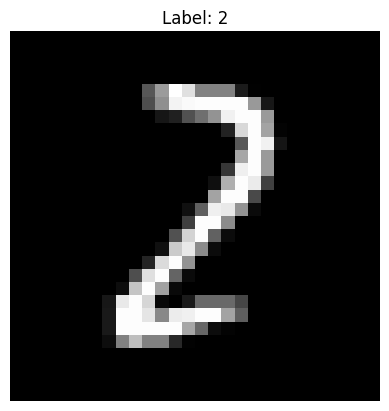

In [5]:
def display_random_image(df):
    # Select a random row, ignoring the first column (label)
    random_index = random.randint(0, len(df) - 1)
    image_data = df.iloc[random_index, 1:].values  # Skip the label
    image_data = image_data.reshape(28, 28).astype(np.uint8)

    # Display the image
    plt.imshow(image_data, cmap='gray')
    plt.title(f"Label: {df.iloc[random_index, 0]}")
    plt.axis('off')
    plt.show()

# Call the function to display a random image
display_random_image(train)

# Preprocess Data

In [6]:
class TrainDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx, 1:].values.astype('float32').reshape(28, 28)  # Adjust shape as needed
        label = self.dataframe.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label

class TestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx].values.astype('float32').reshape(28, 28)  # Adjust shape as needed
        if self.transform:
            image = self.transform(image)
        return image

In [7]:
# Split the dataset into training and validation sets
train_data, val_data = train_test_split(train, test_size=0.05, random_state=42)

# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Create datasets
train_dataset = TrainDataset(train_data, transform=transform)
val_dataset = TrainDataset(val_data, transform=transform)
test_dataset = TestDataset(test, transform=transform)  # Assuming 'test_df' is your test data dataframe

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Define CNN

In [8]:
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 7*7*64)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = DigitCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DigitCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model

In [23]:
num_epochs = 20

# Lists to keep track of metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100. * correct_train / total_train)

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100. * correct_val / total_val)

    print(f'Epoch {epoch}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Training Accuracy: {train_accuracies[-1]}%, Validation Accuracy: {val_accuracies[-1]}%')

Epoch 0, Training Loss: 0.4763206895828868, Validation Loss: 0.12481293156319721, Training Accuracy: 89.30325814536342%, Validation Accuracy: 96.52380952380952%
Epoch 1, Training Loss: 0.16682962766394782, Validation Loss: 0.06712166365292488, Training Accuracy: 95.08771929824562%, Validation Accuracy: 98.14285714285714%
Epoch 2, Training Loss: 0.1276401951603102, Validation Loss: 0.05229205471616958, Training Accuracy: 96.15288220551379%, Validation Accuracy: 98.38095238095238%
Epoch 3, Training Loss: 0.10564644933299114, Validation Loss: 0.06488640876628007, Training Accuracy: 96.84461152882206%, Validation Accuracy: 98.28571428571429%
Epoch 4, Training Loss: 0.09893492472549088, Validation Loss: 0.05750654548010613, Training Accuracy: 97.10275689223057%, Validation Accuracy: 98.19047619047619%
Epoch 5, Training Loss: 0.09077190195817728, Validation Loss: 0.0652739154602662, Training Accuracy: 97.26065162907268%, Validation Accuracy: 98.33333333333333%
Epoch 6, Training Loss: 0.07958

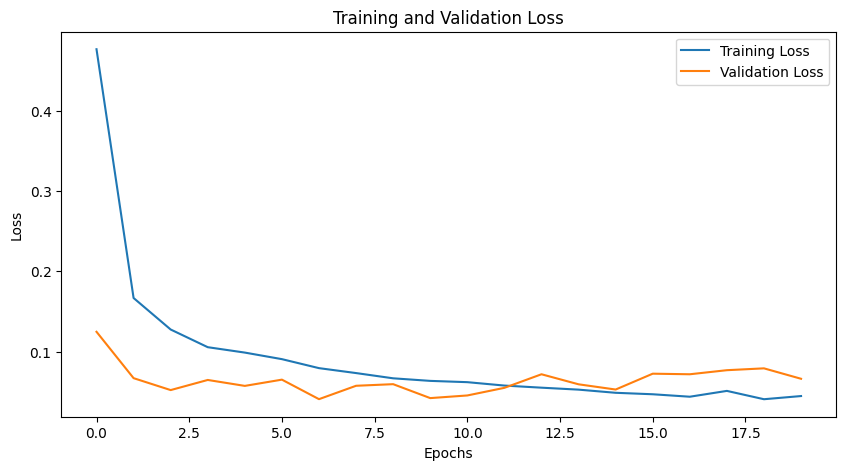

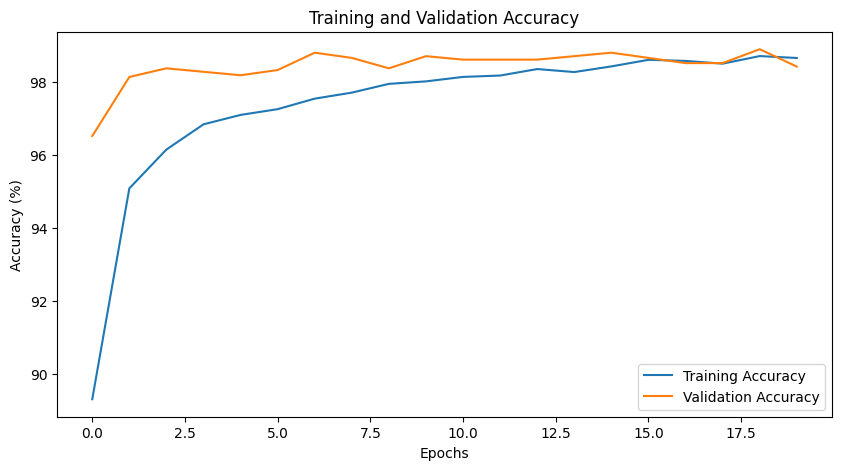

In [24]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Predict Test Set

In [25]:
predictions = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

In [27]:
# Save the entire model
torch.save(model, 'model.pth')

In [30]:
with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list to the file
    for item in predictions:
        writer.writerow([item])

# Load Saved Model

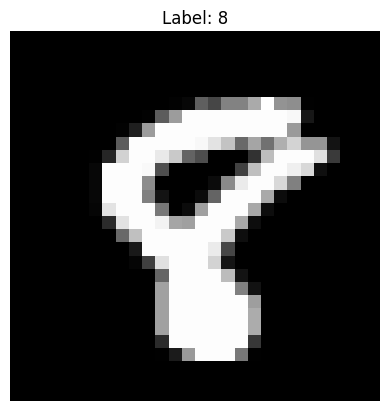

In [14]:
model = torch.load('model.pth')

model.eval()

random_number = random.randint(0, 63)

with torch.no_grad():
  # Iterate over the DataLoader
  for inputs in test_loader:
      # Move inputs and targets to the same device as your model (e.g., GPU)
      inputs = inputs.to(device)

      # Forward pass: Compute predicted outputs by passing inputs to the model
      outputs = model(inputs[random_number])
      _, predicted = torch.max(outputs.data, 1)
      # At this point, you can compare outputs to targets, calculate accuracy, etc.
      # For example, if it's a classification task:
      # _, predicted = torch.max(outputs.data, 1)
      # accuracy = (predicted == targets).sum().item() / targets.size(0)

      # Break after the first batch
      break

# Display the image
image = inputs[random_number].cpu().numpy()
if image.shape[0] == 1:
    image = image.squeeze(0)

plt.imshow(image, cmap='gray')
plt.title(f"Label: {predicted.item()}")
plt.axis('off')
plt.show()